### Constant-NVE Simulation in Extended Phase Space

- **System**: alanine dipeptide in vacuum
- **Force field**: AMBER ff03
- **Constraints**: Bonds to hydrogen atoms
- **Hydrogen mass repartitioning**: 3 Da
- **Phase-space extension**: Circular dynamical variables $\phi_s$ and $\psi_s$ attached to backbone dihedrals $\phi({\bf r})$ and $\psi({\bf r})$, respectively

This example demonstrates how to run a constant-NVE (constant number of particles, volume, and energy) simulation in extended phase space. The extended phase space includes the physical system plus additional dynamical variables (DVs) that are harmonically coupled to collective variables (CVs). We verify the correctness of the implementation by checking energy conservation throughout the simulation.

In [1]:
import io

import cvpack
import ipywidgets as widgets
import numpy as np
import openmm as mm
import pandas as pd
from matplotlib import pyplot as plt
from openmm import app, unit

import openxps as xps

In [2]:
pdb = app.PDBFile("alanine-dipeptide.pdb")
physical_system = app.ForceField("amber03.xml").createSystem(
    pdb.topology,
    nonbondedCutoff=1.0 * unit.nanometer,
    switchDistance=0.8 * unit.nanometer,
    constraints=app.HBonds,
    hydrogenMass=3 * unit.dalton,
)
platform = mm.Platform.getPlatformByName("Reference")

temperature = 300 * unit.kelvin
dv_temperature = 3000 * unit.kelvin


#### Integrator Selection

The extended phase-space simulation requires a special integrator that can handle both the physical system and the dynamical variables. Two options are available:

- **Lockstep**: Integrates both systems simultaneously with the same timestep, then synchronizes the contexts after each step. Requires force-first integrators and equal step sizes.

- **Split**: Uses an operator splitting scheme that allows different timesteps for the physical and extension systems. The timesteps must be related by an even integer ratio. Requires symmetric integrators.

Select the integrator type:

In [3]:
integrator_selector = widgets.Dropdown(
    options=["Lockstep", "Split"],
    value="Split",
    description="Integrator:",
    disabled=False,
)
integrator_selector

Dropdown(description='Integrator:', index=1, options=('Lockstep', 'Split'), value='Split')

In [4]:
physical_step = 2 * unit.femtoseconds
friction = 10.0 / unit.picosecond

if integrator_selector.value == "Lockstep":
    xps_integrator = xps.LockstepIntegrator(
        mm.LangevinIntegrator(temperature, friction, physical_step),
        mm.LangevinIntegrator(dv_temperature, friction, physical_step),
    )
else:
    dv_step = 8 * unit.femtoseconds
    xps_integrator = xps.SplitIntegrator(
        xps.integrators.BAOABIntegrator(temperature, friction, physical_step),
        xps.integrators.BAOABIntegrator(dv_temperature, friction, dv_step),
    )
print(f"Selected integrator: {integrator_selector.value}")

Selected integrator: Split


#### Collective Variables

Our collective variables are the angles $\phi$ and $\psi$, corresponding to backbone dihedrals $C{-}N{-}C_{\alpha}{-}C$ and $N{-}C_{\alpha}{-}C{-}N$, respectively.

In [5]:
backbone_atoms = [
    atom.index for atom in pdb.topology.atoms() if atom.name in ["C", "CA", "N"]
]
phi = cvpack.Torsion(*backbone_atoms[0:4], name="phi")
psi = cvpack.Torsion(*backbone_atoms[1:5], name="psi")

#### Dynamical Variables and Harmonic Coupling

We create circular dynamical variables $\phi_s$ and $\psi_s$ that are harmonically coupled to the collective variables $\phi$ and $\psi$, respectively. The harmonic coupling potential is:

$$U_{\rm coupling} = \frac{1}{2}\kappa_{\phi}[\phi_s - \phi({\bf r})]^2 + \frac{1}{2}\kappa_{\psi}[\psi_s - \psi({\bf r})]^2$$

where $\kappa_{\phi}$ and $\kappa_{\psi}$ are the force constants, and the dynamical variables have masses $m_{\phi_s}$ and $m_{\psi_s}$.

The parameter values (force constants and masses) used here were selected following the procedure in the [parameter selection notebook](parameter-selection.ipynb) to ensure proper adiabatic decoupling.

In [6]:
mass_unit = unit.dalton * (unit.nanometer / unit.radian) ** 2

mass_phi_s = 12 * mass_unit
mass_psi_s = 14 * mass_unit

kappa_phi = 1000 * unit.kilojoule_per_mole / unit.radian**2
kappa_psi = 1150 * unit.kilojoule_per_mole / unit.radian**2

phi_s = xps.DynamicalVariable("phi_s", unit.radian, mass_phi_s, xps.bounds.CIRCULAR)
psi_s = xps.DynamicalVariable("psi_s", unit.radian, mass_psi_s, xps.bounds.CIRCULAR)

coupling = xps.HarmonicCoupling(
    collective_variable=phi, dynamical_variable=phi_s, force_constant=kappa_phi
) + xps.HarmonicCoupling(
    collective_variable=psi, dynamical_variable=psi_s, force_constant=kappa_psi
)

#### Setting Up the Simulation

We create an Extended Space Simulation object with the physical system, coupling potential, and integrator. For proper initialization, we set the initial values of the dynamical variables to match their attached collective variables at the starting configuration.

In [7]:
simulation = xps.ExtendedSpaceSimulation(
    pdb.topology,
    xps.ExtendedSpaceSystem(physical_system, coupling),
    xps_integrator,
    platform,
)
simulation.context.setPositions(pdb.positions)
cv_values = coupling.getCollectiveVariableValues(simulation.context)
simulation.context.setDynamicalVariableValues([cv_values["phi"], cv_values["psi"]])

#### Energy Monitoring

The total energy of the extended phase-space system consists of:
- **Potential energy**: The physical system potential energy, which includes the harmonic coupling potential
- **Physical kinetic energy**: Kinetic energy of the physical atoms
- **Extension kinetic energy**: Kinetic energy of the dynamical variables

We use a reporter to track these energy components throughout the simulation. The output is captured in a StringIO buffer for later analysis.

In [8]:
stream = io.StringIO()
cv_reporter = cvpack.reporting.StateDataReporter(
    stream,
    reportInterval=10,
    step=True,
    time=True,
    temperature=True,
    writers=[
        xps.ExtensionWriter(
            temperature=True,
            dynamical_variables=True,
            collective_variables=True,
        ),
    ],
    speed=True,
)
simulation.reporters.append(cv_reporter)

#### Running the Simulation

We run the simulation for 100 ps. In a constant-NVE simulation with energy-conserving dynamics, the total energy should remain constant (within numerical precision). Any drift in the total energy indicates issues with the integrator or implementation.

In [9]:
total_time = 1 * unit.nanosecond
simulation.step(round(total_time / xps_integrator.getStepSize()))
stream.seek(0)
data = pd.read_csv(stream)
data

,"#""Step""",Time (ps),Temperature (K),Extension Temperature (K),phi_s (rad),psi_s (rad),phi (rad),psi (rad),Speed (ns/day)
0,10,0.08,189.093902,356.717589,3.120837,3.039955,3.112417,3.074460,0.0
1,20,0.16,226.737095,1730.541822,-3.104069,3.024541,-3.074196,2.957407,5260.0
2,30,0.24,260.276931,2875.194030,-3.092761,-3.114064,-3.051748,3.112270,5860.0
3,40,0.32,266.703435,3477.774475,3.056085,-3.036269,3.109679,-3.041517,5890.0
4,50,0.40,259.123854,6474.839139,2.815737,-3.063883,2.851883,-3.028232,5460.0
...,...,...,...,...,...,...,...,...,...
12495,124960,999.68,267.235478,1629.546141,2.190081,-0.273811,2.150314,-0.334433,7090.0
12496,124970,999.76,262.089957,1200.458673,2.125380,-0.217443,2.107994,-0.198742,7090.0
12497,124980,999.84,259.751824,4794.398621,2.017257,-0.212412,1.970093,-0.274222,7090.0
12498,124990,999.92,225.897782,11115.147242,1.795021,-0.276811,1.813033,-0.389721,7090.0


#### Trajectory Analysis

We examine the trajectories of the dynamical variables and their attached collective variables. The harmonic coupling should keep them close to each other, with the DVs following the CVs while the large DV masses (relative to CV effective masses) ensure adiabatic decoupling.

In [10]:
def plot_trajectory(ax, data, angle, max_time=None):
    mask = slice(None) if max_time is None else data["Time (ps)"] <= max_time
    time = data["Time (ps)"][mask]
    dv_traj = np.unwrap(data[mask][f"{angle}_s (rad)"])
    delta = data[mask][f"{angle} (rad)"].values - dv_traj
    cv_traj = dv_traj + delta - 2 * np.pi * np.round(delta / (2 * np.pi))
    ax.plot(time, cv_traj, label=rf"$\{angle}({{\bf r}})$")
    ax.plot(time, dv_traj, label=rf"$\{angle}_s$")
    ax.set_xlabel("Time (ps)")
    ax.set_ylabel("Angle (radians)")
    ax.set_title(rf"Trajectory: $\{angle}({{\bf r}})$ and $\{angle}_s$")
    ax.legend()

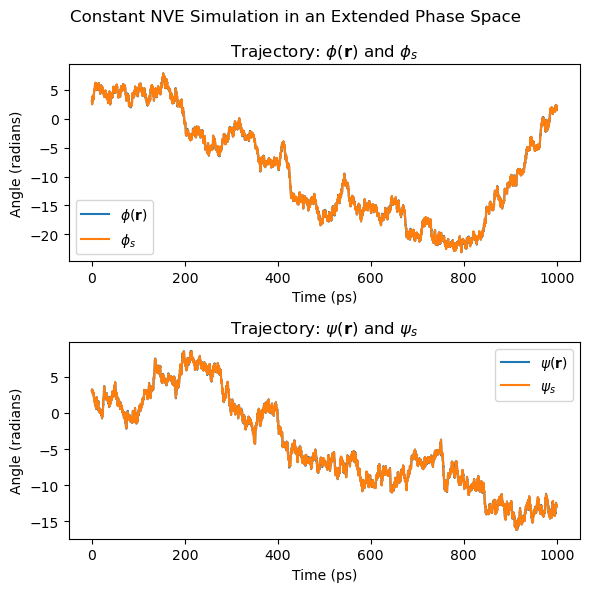

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
plot_trajectory(ax1, data, "phi")
plot_trajectory(ax2, data, "psi")

fig.suptitle("Constant NVE Simulation in an Extended Phase Space")
plt.tight_layout()
plt.show()

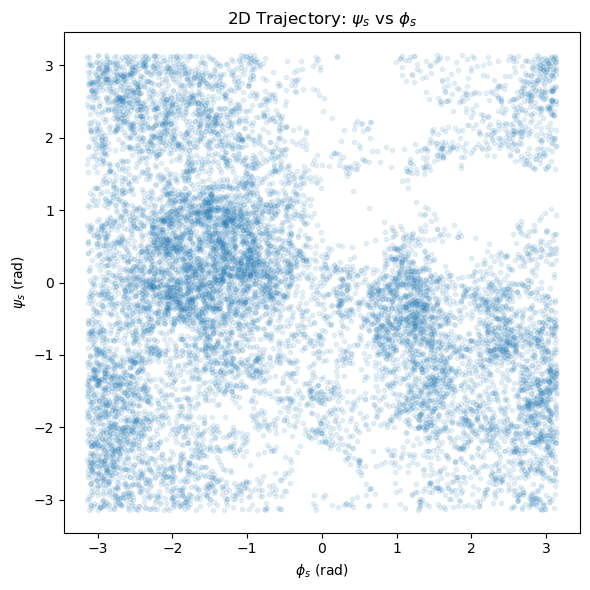

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(data["phi_s (rad)"], data["psi_s (rad)"], marker=".", alpha=0.1)
ax.set_xlabel(r"$\phi_s$ (rad)")
ax.set_ylabel(r"$\psi_s$ (rad)")
ax.set_title(r"2D Trajectory: $\psi_s$ vs $\phi_s$")
plt.tight_layout()
plt.show()


#### Visualizing a Subset of the Trajectory

We zoom into the first 5 ps of the trajectory for better clarity of the CV oscillations around their corresponding DVs.

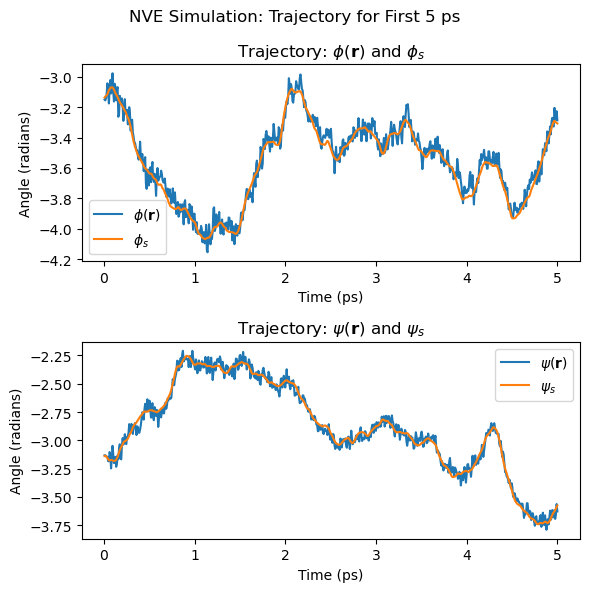

In [13]:
max_time = 5

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
plot_trajectory(ax1, data, "phi", max_time=max_time)
plot_trajectory(ax2, data, "psi", max_time=max_time)

fig.suptitle(f"NVE Simulation: Trajectory for First {max_time} ps")
plt.tight_layout()
plt.show()

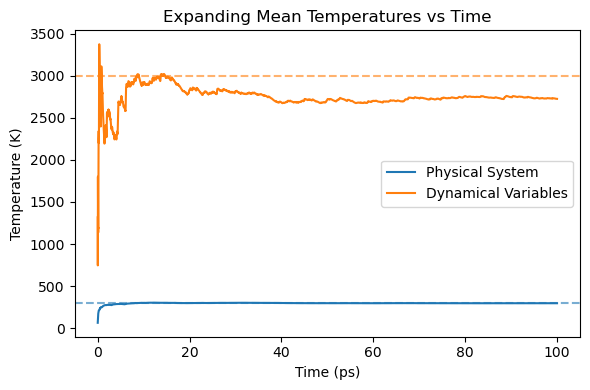

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

expanding_data = data.expanding()

ax.axhline(temperature / unit.kelvin, color="C0", linestyle="--", alpha=0.6)
ax.plot(
    data["Time (ps)"],
    expanding_data["Temperature (K)"].mean(),
    label="Physical System",
    color="C0",
)

ax.axhline(dv_temperature / unit.kelvin, color="C1", linestyle="--", alpha=0.6)
ax.plot(
    data["Time (ps)"],
    expanding_data["Extension Temperature (K)"].mean(),
    label="Dynamical Variables",
    color="C1",
)

ax.set_xlabel("Time (ps)")
ax.set_ylabel("Temperature (K)")
ax.set_title("Expanding Mean Temperatures vs Time")
ax.legend()
plt.tight_layout()
plt.show()
